<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/examplespline_computationgraphworking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

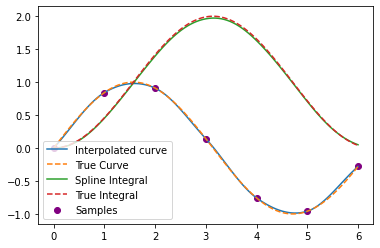

In [1]:
import matplotlib.pylab as P
import torch as T

def h_poly_helper(tt):
  A = T.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  dx = (x[I+1]-x[I])
  hh = h_poly((xs-x[I])/dx)
  return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx

def integ(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  Y = T.zeros_like(y)
  Y[1:] = (x[1:]-x[:-1])*(
      (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
      )
  Y = Y.cumsum(0)
  dx = (x[I+1]-x[I])
  hh = H_poly((xs-x[I])/dx)
  return Y[I] + dx*(
      hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
      )

# Example
if __name__ == "__main__":
  x = T.linspace(0, 6, 7)
  y = x.sin()
  xs = T.linspace(0, 6, 101)
  ys = interp(x, y, xs)
  Ys = integ(x, y, xs)
  P.scatter(x, y, label='Samples', color='purple')
  P.plot(xs, ys, label='Interpolated curve')
  P.plot(xs, xs.sin(), '--', label='True Curve')
  P.plot(xs, Ys, label='Spline Integral')
  P.plot(xs, 1-xs.cos(), '--', label='True Integral')
  P.legend()
  P.show()


In [2]:
x = T.linspace(0,6,7)

In [4]:
y = x.sin()

In [6]:
xs = T.linspace(0, 6, 101)
ys = interp(x, y, xs)


In [83]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 101),
            nn.Tanh()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


In [96]:
model = MLP()

In [97]:
learning_rate = .0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [98]:
#print(xs.shape)
#a = torch.zeros(2,101)
#model(a).shape

In [99]:
model(xs.unsqueeze(0))

tensor([[-0.0349, -0.2309,  0.2260, -0.0635, -0.0512,  0.2023, -0.1249, -0.1263,
          0.1350, -0.2135, -0.0451, -0.1662,  0.0505,  0.0208,  0.1550, -0.0406,
         -0.0163, -0.1137, -0.2225,  0.1352, -0.0971, -0.0594, -0.1386, -0.0558,
          0.0458, -0.1148, -0.0490,  0.0173, -0.1335, -0.1563, -0.1415,  0.0316,
         -0.1903, -0.1549,  0.1062,  0.2188, -0.0535,  0.0013,  0.1790,  0.1521,
          0.1102,  0.0038, -0.0785, -0.1310, -0.2916, -0.0502,  0.0764, -0.1215,
         -0.0659,  0.1115, -0.0106, -0.0760,  0.1706, -0.3068, -0.0134,  0.0009,
         -0.0184,  0.0291, -0.0853,  0.0696,  0.2574, -0.1295,  0.1343,  0.1391,
          0.1739,  0.0083, -0.0291,  0.0175, -0.2326, -0.2889,  0.1755,  0.0221,
         -0.0240, -0.0270, -0.2494, -0.2682,  0.0417,  0.2683, -0.0770, -0.0603,
          0.1529,  0.0857,  0.0790,  0.0893,  0.1843,  0.2145,  0.0898,  0.3175,
          0.0805, -0.0914,  0.2439, -0.1523, -0.1209,  0.0099,  0.1302,  0.1320,
         -0.0860,  0.2160, -

In [100]:
output = model(xs.unsqueeze(0))

In [101]:
output.shape

torch.Size([1, 101])

In [102]:
ys.shape

torch.Size([101])

In [103]:
loss = torch.mean(torch.abs(output-ys))

In [104]:
loss.backward()

In [105]:
optimizer.step()

In [106]:
for i in range(1000):
  output = model(xs.unsqueeze(0))
  loss = torch.mean(torch.abs(output-ys))
  print('loss',loss)
  loss.backward()
  optimizer.step()

loss tensor(0.6747, grad_fn=<MeanBackward0>)
loss tensor(0.6706, grad_fn=<MeanBackward0>)
loss tensor(0.6667, grad_fn=<MeanBackward0>)
loss tensor(0.6628, grad_fn=<MeanBackward0>)
loss tensor(0.6591, grad_fn=<MeanBackward0>)
loss tensor(0.6555, grad_fn=<MeanBackward0>)
loss tensor(0.6518, grad_fn=<MeanBackward0>)
loss tensor(0.6482, grad_fn=<MeanBackward0>)
loss tensor(0.6445, grad_fn=<MeanBackward0>)
loss tensor(0.6411, grad_fn=<MeanBackward0>)
loss tensor(0.6378, grad_fn=<MeanBackward0>)
loss tensor(0.6348, grad_fn=<MeanBackward0>)
loss tensor(0.6319, grad_fn=<MeanBackward0>)
loss tensor(0.6291, grad_fn=<MeanBackward0>)
loss tensor(0.6266, grad_fn=<MeanBackward0>)
loss tensor(0.6242, grad_fn=<MeanBackward0>)
loss tensor(0.6217, grad_fn=<MeanBackward0>)
loss tensor(0.6192, grad_fn=<MeanBackward0>)
loss tensor(0.6165, grad_fn=<MeanBackward0>)
loss tensor(0.6138, grad_fn=<MeanBackward0>)
loss tensor(0.6111, grad_fn=<MeanBackward0>)
loss tensor(0.6082, grad_fn=<MeanBackward0>)
loss tenso

torch.Size([101])


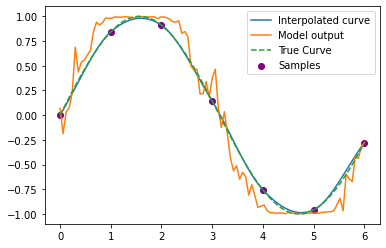

In [107]:
x = T.linspace(0, 6, 7)
y = x.sin()
xs = T.linspace(0, 6, 101)
out = model(xs.unsqueeze(0)).squeeze().detach()
print(xs.shape)
ys = interp(x, y, xs)
Ys = integ(x, y, xs)
P.scatter(x, y, label='Samples', color='purple')
P.plot(xs, ys, label='Interpolated curve')
P.plot(xs, out.numpy(), label='Model output')
P.plot(xs, xs.sin(), '--', label='True Curve')
P.legend()
P.show()
